<a href="https://colab.research.google.com/github/ksydata/DB_FEC_CreditScoringSystem/blob/main/%5BNCB_MICE_NEW%5D_SY_Outlier_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> 은행과 같은 금융기관의 리테일 금융소비자(개인 고객)에 대하여 가계신용대출(Home Credit Loan)을 할 경우 **고객이 대출금을 상환할지 Target 변수 분류 및 대출금액 예측** 프로젝트



> SY



### 이상치 탐지 및 처리기준 수립

자주 일어나는 사건을 예측하거나 분류하기 위해 머신러닝 모델을 만들거나
통계적 가설검정을 하는 것만큼 중요한 것은,

가끔 일어나는 사건, 예를 들어 이상치를 탐지하는 전처리는 모델 성능이나
유의확률[검정 결과]에 영향을 미칠 만큼 중요함. (숙명여대, Chulyun Kim)

Noise는 random error로 이상치 탐지 **전** 제거해야 하는 데이터이며, Outlier(Novel / Anomaly Data)는 우리가 찾고자 하는 이상치를 말함. (고려대, Pilsung Kang)

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import missingno as msno
from typing import *
  # [데이터프레임 핸들링, 선형대수, 결측값 처리 목적 라이브러리 모듈]

from google.colab import drive
drive.mount("/content/drive")
  # [코랩에 구글 드라이브 마운트]

from sklearn.preprocessing import *
  # [연속형 변수 스케일링 및 범주형 변수 인코딩 목적 모든 라이브러리 모듈]
from sklearn.model_selection import train_test_split
  # [훈련용 및 검증용 데이터 셋 분할 목적 라이브러리 모듈]
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
  # [K-폴드 교차검증(랜덤 또는 타겟하는 클래스 변수 비율 층화) 및 그리드 서치 목적 라이브러리 모듈]

import matplotlib.pyplot as plt
import seaborn as sns
  # [데이터 시각화 모듈]

from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from scipy.spatial import distance
  # [distance.euclidean(x, y)]
from math import dist
  # [dist(x, y)]
from sklearn.neighbors import DistanceMetric
  # [이상치 탐지 목적 모듈]

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
  # [차원축소 후 2 또는 3차원 시각화 모듈]

from sklearn.metrics import *
  # [혼동행렬 등 분류모델 성능평가 모듈]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install hdbscan
import hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
NCB_MICE_FS = pd.read_csv("/content/drive/MyDrive/NCB_MICE_NEW.csv", index_col = False)
  # [NA 대체, 범주형 변수 원핫인코딩, Feature Selection 완료된 데이터프레임 로드]



* NCB_MICE_FS

  New Credit Bureau

  MICE which impute NA to predictions generated by Random Forest model

  Feature Selected Version

* 범주형 변수는 더미 변수로 인코딩 완료하였으나 연속형 변수는 이상치 탐지, 판정, 처리를 위해 단위 스케일링을 수행하지 않은 데이터

In [ ]:
NCB_MICE_FS.iloc[:, 7:125] = NCB_MICE_FS.iloc[:, 7:125].astype("uint8")
  # [더미변수를 "64비트(8바이트)의 부호 있는 정수형"에서 "8비트(1바이트)의 부호 없는 정수형" 변환]
  # [메모리 공간 사용 영역을 줄이기 위한 목적]

In [ ]:
NCB_MICE_FS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313975 entries, 0 to 313974
Columns: 129 entries, AMT_ANNUITY_y to SK_ID_PREV
dtypes: float64(8), int64(3), uint8(118)
memory usage: 61.7 MB


In [ ]:
NCB_MICE_FS.size

40502775

In [ ]:
NCB_MICE_FS["duplicate"] = NCB_MICE_FS["SK_ID_CURR"].duplicated()

<ipython-input-12-57eb666f4bd6>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  NCB_MICE_FS["duplicate"] = NCB_MICE_FS["SK_ID_CURR"].duplicated()


In [ ]:
NCB_MICE_FS["duplicate"].value_counts()
    # [과거 ID인 SK_ID_PREV가 달라 신용대출을 중복하여 받은 이력이 있는 현재 ID인 SK_ID_CURR이 동일한 고객이 존재함]

False    178924
True     135051
Name: duplicate, dtype: int64

In [ ]:
NCB_MICE_FS["duplicate"] = NCB_MICE_FS["duplicate"].astype("uint8")
NCB_MICE_FS["duplicate"].value_counts()

0    178924
1    135051
Name: duplicate, dtype: int64

In [ ]:
# 연속형 독립변수 0 ~ 6, 126, 129열과 종속변수 124, 125열 상관관계 분석

correlation = NCB_MICE_FS.iloc[:, [0, 1, 2, 3, 4, 5, 6, 124, 125, 126, 129]].corr()
  # [NCB_MICE_FS 데이터프레임의 Correlation Matrix]
mask = np.zeros_like(correlation, dtype = np.bool)
    # [상관분석 히트맵 삼각형 마스크(위 쪽 삼각형에 True, 아래 삼각형에 False)]
mask[np.triu_indices_from( mask )] = True

<ipython-input-15-f6285301584d>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlation, dtype = np.bool)


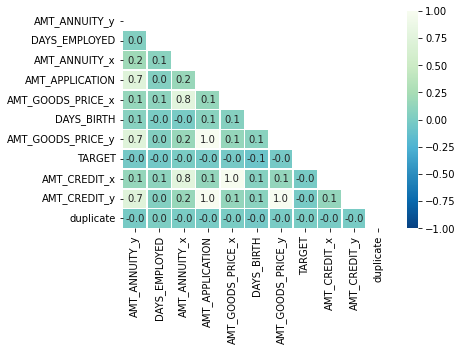

In [ ]:
# 상관계수 히트맵

sns.heatmap(data = correlation,
            cmap = "GnBu_r",
              # [colormap 팔레트]
            annot = True,
              # [실제값 표시]
            fmt = "0.01f",
              # [소수점 둘째 자리까지 표시]
            mask = mask,
              # [표시하지 않을 위쪽 삼각형 마스크 부분 지정]
            linewidths = 0.5,
              # [경계면 실선으로 구분]
            vmin = -1,
            vmax = 1
              # [colorbar의 범위 -1 ~ 1로 지정]
            )
plt.show()
  # [분류모델 종속변수 TARGET과 상관관계 있는 연속형 변수 無]
  # [회귀분석 종속변수 AMT_CREDIT_x와 상관관계 있는 연속형 변수] AMT_AUNNUITY_x, AMT_GOODS_PRICE_x

##### 1. Z-점수(μ±3σ 규칙)

  저차원 특징 공간에서 파라메트릭 이상치 감지 방법이며

  데이터의 가우시안 분포를 가정하기 때문에 이상치 판정기준으로 부적절함

##### 2. 상자도표(boxplot)을 이용한 Q3 + 1.5*IQR(상위 경계) 이상이거나 Q1 - 1.5*IQR(하위 경계) 이하인 관측값

  이상치로 판정하기에는 제거되는 행이 많다는 문제로 인하여 채택하지 않음

  다변량 설정이나 고차원 데이터에는 큰 가치가 없음

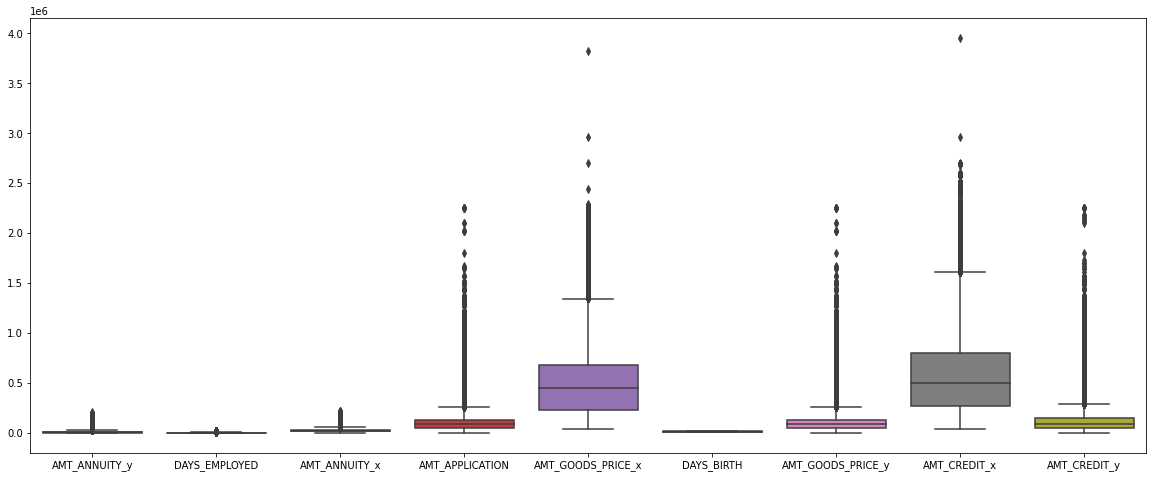

In [ ]:
# 박스플롯 시각화

f, axes = plt.subplots(figsize = (20, 8))
sns.boxplot(data = NCB_MICE_FS.iloc[:, [0, 1, 2, 3, 4, 5, 6, 125, 126]])
  # [제3분위수 + 1.5*IQR 이상인 값을 제거하는 방식은 적절하지 않다고 판단]

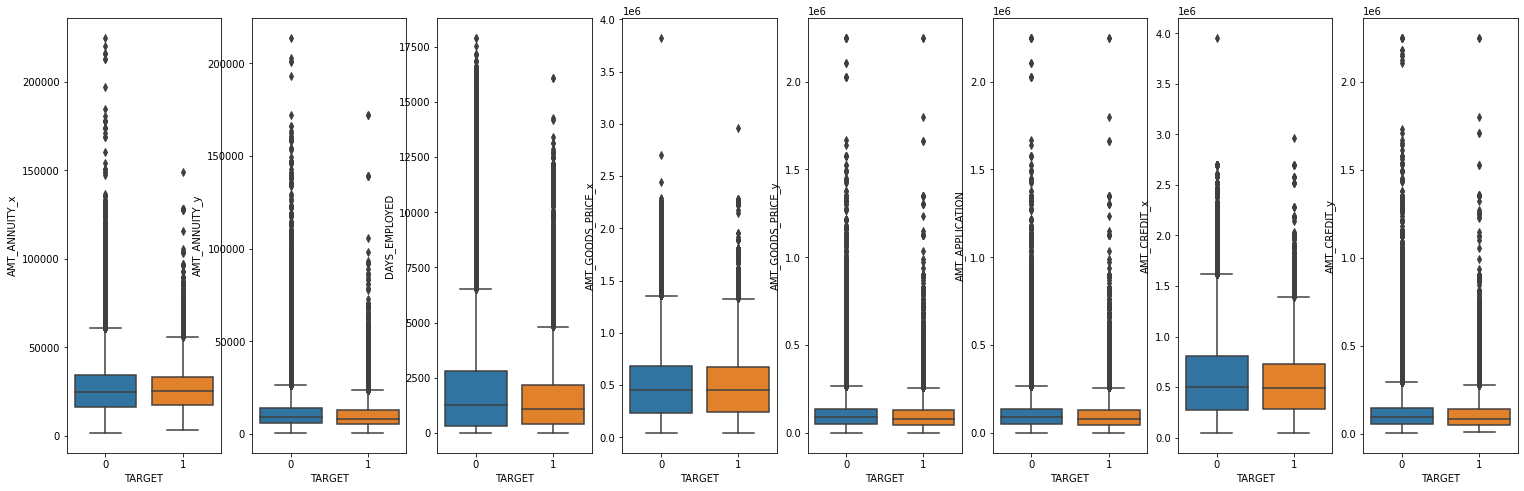

In [ ]:
# 박스플롯 시각화

f, axes = plt.subplots(ncols = 8, figsize = (26, 8))

sns.boxplot(y = "AMT_ANNUITY_x", x = "TARGET", data = NCB_MICE_FS.iloc[:, [0, 1, 2, 3, 4, 5, 6, 124, 125, 126]], ax = axes[0])
sns.boxplot(y = "AMT_ANNUITY_y", x = "TARGET", data = NCB_MICE_FS.iloc[:, [0, 1, 2, 3, 4, 5, 6, 124, 125, 126]], ax = axes[1])
sns.boxplot(y = "DAYS_EMPLOYED", x = "TARGET", data = NCB_MICE_FS.iloc[:, [0, 1, 2, 3, 4, 5, 6, 124, 125, 126]], ax = axes[2])

sns.boxplot(y = "AMT_GOODS_PRICE_x", x = "TARGET", data = NCB_MICE_FS.iloc[:, [0, 1, 2, 3, 4, 5, 6, 124, 125, 126]], ax = axes[3])
sns.boxplot(y = "AMT_GOODS_PRICE_y", x = "TARGET", data = NCB_MICE_FS.iloc[:, [0, 1, 2, 3, 4, 5, 6, 124, 125, 126]], ax = axes[4])

sns.boxplot(y = "AMT_APPLICATION", x = "TARGET", data = NCB_MICE_FS.iloc[:, [0, 1, 2, 3, 4, 5, 6, 124, 125, 126]], ax = axes[5])
sns.boxplot(y = "AMT_CREDIT_x", x = "TARGET", data = NCB_MICE_FS.iloc[:, [0, 1, 2, 3, 4, 5, 6, 124, 125, 126]], ax = axes[6])
sns.boxplot(y = "AMT_CREDIT_y", x = "TARGET", data = NCB_MICE_FS.iloc[:, [0, 1, 2, 3, 4, 5, 6, 124, 125, 126]], ax = axes[7])
  # [분류모델 종속변수 TARGET의 0과 1(상환리스크)를 구분할 수 있는 연속형 변수는 시각적으로 없다고 판단]

##### 3. 비모수적 밀도 기반의 군집분석에 의한 이상치 탐지(DBSCAN, Density-Based Spatial Clustering of Applications with Noise, Global Outlier)

  필요한 이웃 수(MinPts), 거리(ℇ), 선택한 거리 측정값(예: Euclidean 또는 Manhattan)에 따라 이상치로 식별되는 노이즈 포인트가 달라짐

  minPoints는 일반적으로 차원 수(컬럼 수)의 2배 적용, 단 도메인 지식이 그 가치를 결정

  일반적인 관측치와 많이 동떨어진 관측치로 얼마나 떨어져있는지 측정하는 것이 튜닝할 하이퍼파라미터

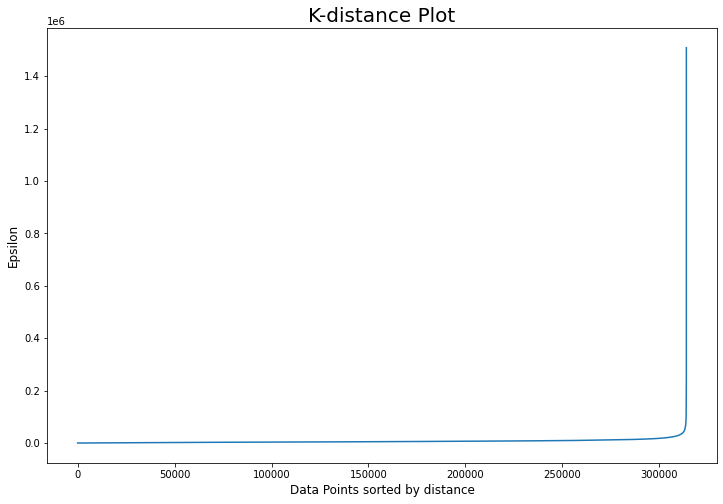

In [ ]:
# epsilon(거리) 크기 정하기 위한 K-distance Plot

neighbors = NearestNeighbors(n_neighbors = 2)
knn = neighbors.fit(NCB_MICE_FS.iloc[:, [0, 1, 2, 3, 4, 5, 6, 124, 125, 126, 129]])
distances, indices = knn.kneighbors(NCB_MICE_FS.iloc[:, [0, 1, 2, 3, 4, 5, 6, 124, 125, 126, 129]])

K_distances = np.sort(distances, axis = 0)
K_distances = K_distances[:, 1]

plt.figure(figsize = (12, 8))
plt.plot(K_distances)

plt.title("K-distance Plot", fontsize = 20)
plt.xlabel("Data Points sorted by distance", fontsize = 12)
plt.ylabel("Epsilon", fontsize = 12)

plt.show()
  # [최대 Epsilon 값이 0.05에 근접하며, minimum points 이웃 데이터의 수는 3000,000/100 = 300으로 최적화]

In [ ]:
# 하이퍼파라미터인 epsilon과 minPoints 값 최적화 후 DBSCAN

dbscan = DBSCAN(
    algorithm = "auto",
    eps = 1000,
    metric = "euclidean",
    metric_params = None,
    min_samples = 5,
    n_jobs = None,
    p = None
)
  # [거리, epsilon] 0.5 -> 0.05 -> 0.03 -> 0.001 -> 0.005
  # [최소 필요한 이웃 수, minimum points(min_samples)] 260 -> 300 -> 260 -> 30 -> 20
  # [거리 측정값, metric] 유클리디안(L2) 거리(피타고라스)
  # [모든 데이터(313975행의 관측값)가 이상치로 탐지(-1)되는 오류 지속적으로 발생]

In [ ]:
outlier_dbscan = dbscan.fit(NCB_MICE_FS.iloc[:, [0, 1, 2, 3, 4, 5, 6, 124, 125, 126, 129]])
  # [실행시간] 모든 데이터 + 하이퍼파라미터 디폴트 설정 시 26분 58초
  # [실행시간] 연속형 변수 및 종속변수만 포함된 데이터 0 ~ 8초

In [ ]:
# DBSCAN으로 탐지한 이상치 열 생성

'''
labels = outlier_dbscan.labels_
NCB_MICE_FS["dbscan_anomaly_score"] = labels
NCB_MICE_FS["dbscan_anomaly_score"].value_counts()
'''

'\nlabels = outlier_dbscan.labels_\nNCB_MICE_FS["dbscan_anomaly_score"] = labels\nNCB_MICE_FS["dbscan_anomaly_score"].value_counts()\n'

In [ ]:
# DBSCAN으로 탐지한 minPoints  미만의 epsilon 반경 밖 이상치 데이터프레임

df_outlier_dbscan = NCB_MICE_FS[outlier_dbscan.labels_ == -1]
print(df_outlier_dbscan.shape)
df_outlier_dbscan.head()
  # [모든 데이터(313975행의 관측값)가 이상치로 탐지(-1)되는 오류 지속적으로 발생]
  # [거리(epsilon) 값을 0.0005로 극단적으로 줄여도 313975행 중 313239행의 관측값을 이상치로 판정]

(312731, 130)


,AMT_ANNUITY_y,DAYS_EMPLOYED,AMT_ANNUITY_x,AMT_APPLICATION,AMT_GOODS_PRICE_x,DAYS_BIRTH,AMT_GOODS_PRICE_y,CODE_GENDER_M,CODE_GENDER_F,NAME_EDUCATION_TYPE_Higher education,...,NAME_GOODS_CATEGORY_Tourism,NAME_GOODS_CATEGORY_Vehicles,NAME_GOODS_CATEGORY_Weapon,NAME_GOODS_CATEGORY_XNA,TARGET,AMT_CREDIT_x,AMT_CREDIT_y,SK_ID_CURR,SK_ID_PREV,duplicate
0,9251.775,637,24700.5,179055.0,351000.0,9461,179055.0,1,0,0,...,0,1,0,0,1,406597.5,179055.0,100002,1038818.0,0
1,64567.665,1188,35698.5,337500.0,1129500.0,16765,337500.0,0,1,1,...,0,0,0,0,0,1293502.5,348637.5,100003,2636178.0,0
2,17885.835,1588,27517.5,162598.5,454500.0,16941,162598.5,1,0,0,...,0,0,0,0,0,490495.5,162598.5,100008,2218188.0,0
3,8996.760,3130,41301.0,98239.5,1395000.0,13778,98239.5,0,1,1,...,0,0,0,0,0,1560726.0,98239.5,100009,1413109.0,0
4,27463.410,449,42075.0,247212.0,1530000.0,18850,247212.0,1,0,1,...,0,0,0,0,0,1530000.0,260811.0,100010,2349489.0,0


In [ ]:
NCB_MICE_FS[outlier_dbscan.labels_ != -1]
  # [736개 행이 이상치 아닌 데이터로 탐지됨]

,AMT_ANNUITY_y,DAYS_EMPLOYED,AMT_ANNUITY_x,AMT_APPLICATION,AMT_GOODS_PRICE_x,DAYS_BIRTH,AMT_GOODS_PRICE_y,CODE_GENDER_M,CODE_GENDER_F,NAME_EDUCATION_TYPE_Higher education,...,NAME_GOODS_CATEGORY_Tourism,NAME_GOODS_CATEGORY_Vehicles,NAME_GOODS_CATEGORY_Weapon,NAME_GOODS_CATEGORY_XNA,TARGET,AMT_CREDIT_x,AMT_CREDIT_y,SK_ID_CURR,SK_ID_PREV,duplicate
284,19684.800,0,15709.5,180000.0,225000.0,24006,180000.0,0,1,0,...,0,0,0,1,0,254700.0,180000.0,100303,1480321.0,0
285,5834.700,0,15709.5,45000.0,225000.0,24006,45000.0,0,1,0,...,0,0,0,1,0,254700.0,47475.0,100303,2651663.0,1
286,5246.010,0,15709.5,45000.0,225000.0,24006,45000.0,0,1,0,...,0,0,0,1,0,254700.0,47970.0,100303,1099943.0,1
580,7073.865,155,9000.0,69705.0,180000.0,8126,69705.0,0,1,0,...,0,0,0,0,0,180000.0,69705.0,100614,1615263.0,0
1056,10588.905,0,16011.0,90000.0,225000.0,23942,90000.0,0,1,0,...,0,0,0,1,0,284400.0,95940.0,101133,2788357.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311783,5246.010,0,24939.0,45000.0,225000.0,24704,45000.0,0,1,0,...,0,0,0,1,0,254700.0,47970.0,453802,2529167.0,1
313053,4090.365,0,14220.0,27360.0,225000.0,24281,27360.0,0,1,0,...,0,0,0,0,0,254700.0,29619.0,455310,2661857.0,0
313469,10492.020,0,14350.5,90000.0,225000.0,24022,90000.0,0,1,0,...,0,0,0,1,0,254700.0,95940.0,455737,1855749.0,0
313470,8072.235,0,14350.5,67500.0,225000.0,24022,67500.0,0,1,0,...,0,0,0,1,0,254700.0,71955.0,455737,2178966.0,1


In [ ]:
# colors = outlier_dbscan.labels
# plt.scatter(NCB_MICE_FS, c = colors)
  # [DBSCAN 클러스터링 시각화]

##### 4. 격리 포레스트(Isolated Forest, Global Outlier)


* NCB_Isolation의 IF_anomaly_score

  데이터 세트를 랜덤한 의사결정나무로 표현하여 이상치를 의사결정나무 상단 노드에서 분리하는(짧은 경로 길이를 생성하는) 밀도 기반의 이상치 탐지하는 알고리즘

  분류 모형을 생성하여 모든 관측치를 고립시켜 나가면서 분할 횟수로 이상치를 탐색하며, 모형에서 적은 횟수로 Leaf 노드에 도달하는 관측치일수록 이상치일 가능성이 크다고 판단

  각 샘플의 이상 점수를 반환

```
The novelty score s(x, n) = 2^( E(h(x))/c(n) )
  # [h(x)] 관측값 x의 경로 길이
  # [c(n)] 이진검색트리에서 실패한 검색의 평균 경로 길이
  # [n] 외부 노드의 수

  # [E(h(x)) = c(n)] s(x, n) = 0.5
  # [E(h(x)) = 0, s(x, n) = 1]
  # [E(h(x)) = n -1, s(x, n_ = 0]
```

  https://github.com/Albertsr/Anomaly-Detection/blob/master/UnSupervised-Isolation%20Forest/Isolation%20Forest.pdf

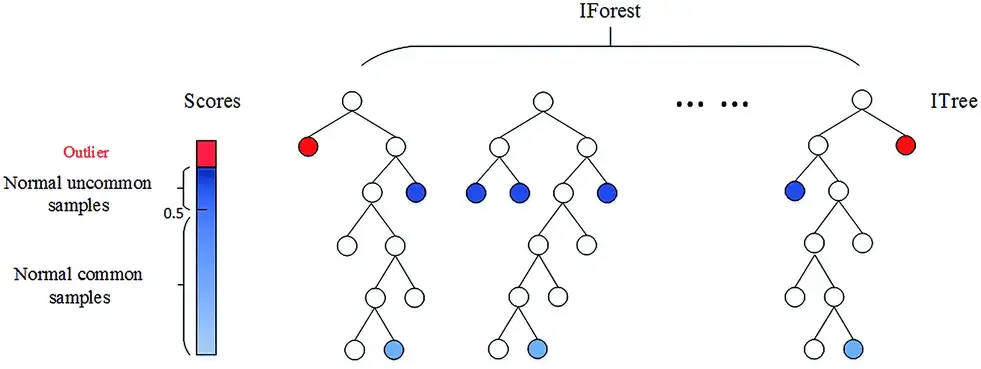

In [ ]:
x_train_outlier, x_test_outlier = train_test_split(NCB_MICE_FS.iloc[:, [0, 1, 2, 3, 4, 5, 6, 125, 126]],
                                                   test_size = 0.5,
                                                   random_state = 2022)
  # [비지도학습이므로 y 없다고 가정하고 데이터 분할]

In [ ]:
print(x_train_outlier.shape, x_test_outlier.shape)

(156987, 9) (156988, 9)


In [ ]:
isolation_outlier = IsolationForest(n_estimators = 50,
                                    max_samples = 1000,
                                    contamination = float(0.001),
                                    max_features = 1.0,
                                    bootstrap = False,
                                    n_jobs = None,
                                    random_state = 2023,
                                    verbose = 0)
  # [50개 노드 수] [최대 1000개 샘플] [0.1%의 이상치 색출(오염 정도)]

In [ ]:
isolation_outlier.fit(x_train_outlier)
  # [UserWarning] X does not have valid feature names, but IsolationForest was fitted with feature names

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.001, max_samples=1000, n_estimators=50,
                random_state=2023)

In [ ]:
pred_train = isolation_outlier.predict(x_train_outlier)
pred_test = isolation_outlier.predict(x_test_outlier)

In [ ]:
isolation_outlier.fit(x_test_outlier)
refer_test = isolation_outlier.predict(x_test_outlier)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
# 이상치 탐지모델, 격리 포레스트(iTree)의 성능평가 (detection score = recall)

print("검증용 데이터 예측된 이상치 :", Counter(pred_test))
print("검증용 데이터 실제 이상치 :", Counter(refer_test))

검증용 데이터 예측된 이상치 : Counter({1: 156813, -1: 175})
검증용 데이터 실제 이상치 : Counter({1: 156831, -1: 157})


In [ ]:
isolation_cf = confusion_matrix(refer_test, pred_test)
isolation_cf

array([[   124,     33],
       [    51, 156780]])

In [ ]:
isolation_cf_plot = ConfusionMatrixDisplay(confusion_matrix = isolation_cf)

([<matplotlib.axis.YTick at 0x7fd8f8b431c0>,
 [Text(0, 0.5, 'reference outlier'), Text(0, 1.5, 'reference inlier')])

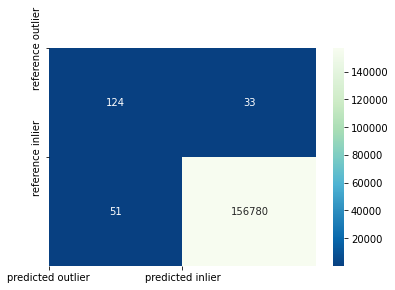

In [ ]:
sns.heatmap(isolation_cf, annot = True, fmt = ".0f", cmap = "GnBu_r")

tick_marks = np.arange(2, 2)
plt.xticks(np.arange(2), ("predicted outlier", "predicted inlier"))
plt.yticks(np.arange(2), ("reference outlier", "reference inlier"))

In [ ]:
124 / (124 + 33)
  # [Recall = TP / (TP + FN)] 재현율

0.7898089171974523

In [ ]:
124 / (124 + 51)
  # [Precision = TP / (TP + FP)] 정밀도(민감도)

0.7085714285714285

이상치 탐지모델, 격리 포레스트(iTree)의 성능평가 결과
* detection score = recall = $ \frac{TP}{TP + FN} $ = 78.98%
* 실제 중에 얼마나 맞았는지를 측정하여 양성을 찾아 내는 것이 중요한 경우

In [ ]:
print(len(pred_test), len(pred_test[pred_test != 1]))
  # [데이터 포인트가 -1이면 이상치로 탐지된 것]
  # [검증 데이터의 이상치 371행(모든 변수) / 390행(연속형 변수) / 34행(연속형 변수의 0.05%의 이상치) / 127행(0.08%의 이상치)]

156988 175


In [ ]:
print(len(pred_train), len(pred_train[pred_train != 1]))
  # [훈련 데이터의 이상치 880행(동일) / 110행(연속형 변수의 0.05%의 이상치) / 124행(0.08%의 이상치))]

156987 157


In [ ]:
x_train_outlier["IF_anomaly_score"] = pred_train
x_test_outlier["IF_anomaly_score"] = pred_test
  # [이상치 점수(맞으면 -1, 아니면 1)를 변수로 생성]

In [ ]:
NCB_Isolation = pd.concat(
    [x_train_outlier, x_test_outlier],
    axis = 0
)

In [ ]:
NCB_Isolation.sort_index(inplace = True)

In [ ]:
outlier_index = NCB_Isolation[NCB_Isolation["IF_anomaly_score"] == -1].index.tolist()

In [ ]:
len(outlier_index)

332

In [ ]:
NCB_Isolation[NCB_Isolation["IF_anomaly_score"] == -1]
  # [313975개 행 중 1251개 행 / 1284개 행 / 144개 행 / 251개 행 / 332개 행의 관측값이 이상치로 탐지됨]

,AMT_ANNUITY_y,DAYS_EMPLOYED,AMT_ANNUITY_x,AMT_APPLICATION,AMT_GOODS_PRICE_x,DAYS_BIRTH,AMT_GOODS_PRICE_y,AMT_CREDIT_x,AMT_CREDIT_y,IF_anomaly_score
46,62464.500,768,23157.0,1575000.0,553500.0,17199,1575000.0,641173.5,1575000.0,-1
47,83916.000,768,23157.0,1575000.0,553500.0,17199,1575000.0,641173.5,1575000.0,-1
48,49034.655,768,23157.0,1125000.0,553500.0,17199,1125000.0,641173.5,1236375.0,-1
62,145794.600,6977,34596.0,1305000.0,675000.0,18632,1305000.0,675000.0,1305000.0,-1
1046,163512.000,0,32796.0,900000.0,585000.0,18656,900000.0,585000.0,900000.0,-1
...,...,...,...,...,...,...,...,...,...,...
311320,46742.625,0,49270.5,864643.5,1665000.0,23345,864643.5,1862802.0,864643.5,-1
312328,53895.285,3702,93838.5,1125000.0,1710000.0,22104,1125000.0,1710000.0,1272015.0,-1
312330,44894.250,3702,93838.5,675000.0,1710000.0,22104,675000.0,1710000.0,733806.0,-1
312331,43116.210,3702,93838.5,900000.0,1710000.0,22104,900000.0,1710000.0,1017612.0,-1


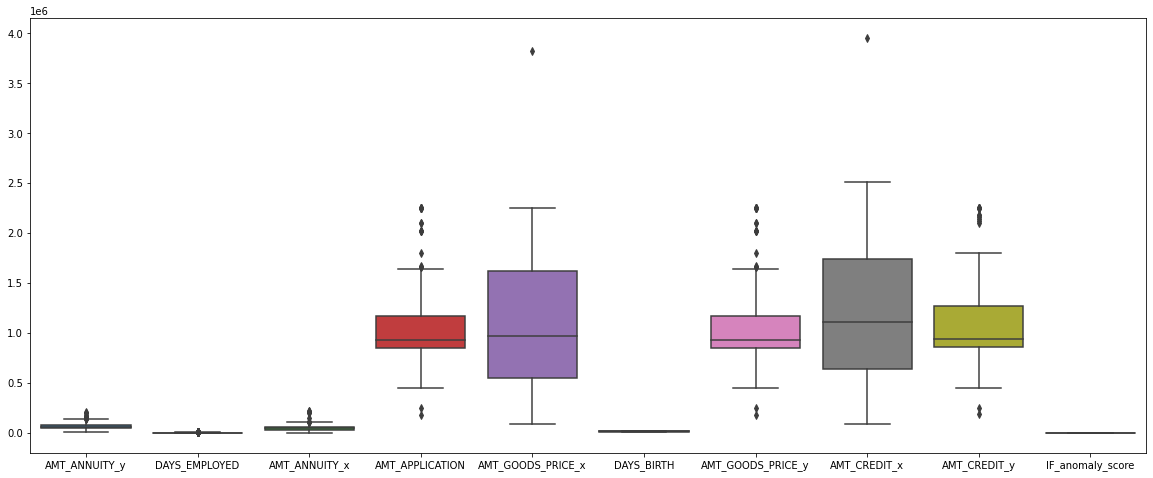

In [ ]:
# 이상치로 탐지된 데이터만 상자도표(boxplot) 시각화 -> 저차원에 적합한 시각화로 격리 포레스트 모델의 이상치 탐지 성능 평가에 적합하지 않음

f, axes = plt.subplots(ncols = 1, figsize = (20, 8))
sns.boxplot(data = NCB_Isolation[NCB_Isolation["IF_anomaly_score"] == -1])

In [ ]:
# 3차원 축소(PCA) 후 시각화(PCA plot)

IF_PCA = PCA(n_components = 3)
# scaler = MinMaxScaler()
  # [탐지된 이상값을 이상치로 판정하기 위한 시각화를 위해 정규화를 시행하지 않음]

In [ ]:
# NCB_IF = scaler.fit_transform(NCB_Isolation)
  # [normalize the metrics]
NCB_IF_reduction = IF_PCA.fit_transform(NCB_Isolation)

In [ ]:
IF_PCA.explained_variance_ratio_.cumsum()
  # [주성분 1, 2, 3의 10개 연속형 변수에 대하여 설명가능한 분산의 누적 기여율]

array([0.8957077 , 0.99339512, 0.99932954])

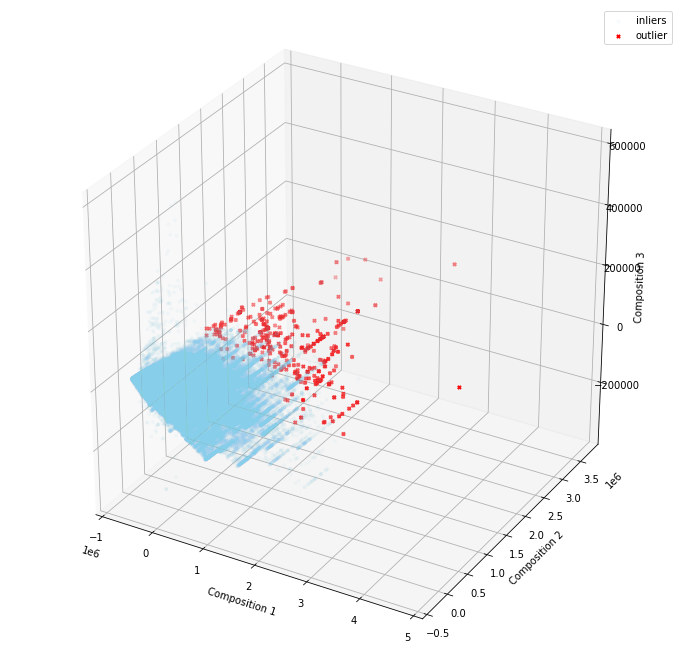

In [ ]:
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111, projection = "3d")

ax.set_xlabel("Composition 1")
ax.set_ylabel("Composition 2")
ax.set_zlabel("Composition 3")

ax.scatter(NCB_IF_reduction[:, 0],
           NCB_IF_reduction[:, 1],
           NCB_IF_reduction[:, 2],
           s = 8, lw = 1, alpha = 0.05, label = "inliers", c= "skyblue")

ax.scatter(NCB_IF_reduction[outlier_index, 0],
           NCB_IF_reduction[outlier_index, 1],
           NCB_IF_reduction[outlier_index, 2],
           s = 10, lw = 2, label = "outlier", c = "red", marker = "x")

ax.legend()
plt.show()

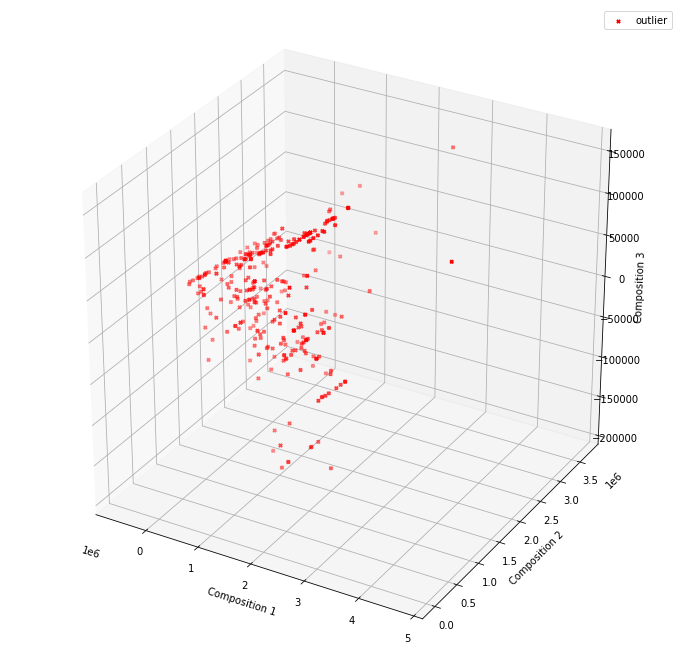

In [ ]:
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111, projection = "3d")

ax.set_xlabel("Composition 1")
ax.set_ylabel("Composition 2")
ax.set_zlabel("Composition 3")

ax.scatter(NCB_IF_reduction[outlier_index, 0],
           NCB_IF_reduction[outlier_index, 1],
           NCB_IF_reduction[outlier_index, 2],
           s = 10, lw = 2, label = "outlier", c = "red", marker = "x")

ax.legend()
plt.show()

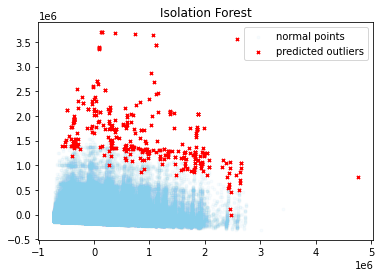

In [ ]:
IF_PCA2 = PCA(n_components = 2)
NCB_IF_reduction2 = pd.DataFrame(IF_PCA2.fit_transform(NCB_Isolation))

plt.title("Isolation Forest")
b1 = plt.scatter(NCB_IF_reduction2[0], NCB_IF_reduction2[1],
                 c = "skyblue", s = 8, alpha = 0.05, label = "normal points")

b1 = plt.scatter(NCB_IF_reduction2.iloc[outlier_index, 0], NCB_IF_reduction2.iloc[outlier_index, 1],
                 c = "red", s = 10, marker = "x", label = "predicted outliers")

plt.legend(loc = "upper right")
plt.show()

In [ ]:
IF_PCA2.explained_variance_ratio_.cumsum()

array([0.8957077 , 0.99339512])

In [ ]:
x_train_outlier.drop(["IF_anomaly_score"], axis = 1, inplace = True)
x_test_outlier.drop(["IF_anomaly_score"], axis = 1, inplace = True)
  # [이상치 탐지 모델의 detection rated은 recall과 같음]

In [ ]:
NCB_Isolation["TARGET"] = NCB_MICE_FS["TARGET"]

In [ ]:
NCB_Isolation.TARGET.value_counts()

0    288205
1     25770
Name: TARGET, dtype: int64

In [ ]:
NCB_Isolation.groupby("IF_anomaly_score")["TARGET"].count()
  # [신용대출 상환여부 클래스별 이상치 여부 집계] -> 실패

IF_anomaly_score
-1       332
 1    313643
Name: TARGET, dtype: int64

In [ ]:
len(NCB_Isolation[(NCB_Isolation["TARGET"] == 1) & (NCB_Isolation["IF_anomaly_score"] == -1)])
  # [연체 위험(신용 리스크) 있는 고객의 관측값이 이상치로 탐지된 경우 25,770행 중 26행]

26

In [ ]:
len(NCB_Isolation[(NCB_Isolation["TARGET"] == 0) & (NCB_Isolation["IF_anomaly_score"] == -1)])
  # [우량 ~ 보통 신용등급 고객의 관측값이 이상치로 탐지된 경우  288,205행 중 306행]

306

##### 5. One Class SVM(OC-SVM)

  비지도학습 기반의 서포트 벡터 머신을 이용한 이상치 탐지 알고리즘

```
min 1/2*||w||^2 + 1/vn * sigma(psi)
  # [psi] 데이터와 초평면(hyperplane)과의 거리
  # [psi] epsilon - p

  # [w, epsilon, p(rho)] 편미분하여 세 가지 조건의 제약식 도출
```
https://www.dfki.de/fileadmin/user_upload/import/6957_One-class-SVM_anomaly-detection.pdf
https://limitsinx.tistory.com/147

```
x_train_outlier, x_test_outlier = train_test_split(NCB_MICE_FS.iloc[:, [0, 1, 2, 3, 4, 5, 6, 125, 126]], test_size = 0.5, random_state = 2022)
```

```
svm_outlier = svm.OneClassSVM(nu = 0.004, kernel = "rbf", gamma = 0.001)
svm_outlier.fit(x_train_outlier)
  # [실행시간] 훈련 데이터 셋 (70%, 1시간 20분 경과) -> 훈련 데이터 셋 (50%, 32분)
  # [하이퍼파라미터인 nu 전체 데이터 중 이상치로 판정할 비율 및 gamma 초평면 경계 비율을 튜닝하여야 머신러닝 모델 최적화 가능]
```

```
svm_pred_train = svm_outlier.predict(x_train_outlier)
svm_pred_test = svm_outlier.predict(x_test_outlier)
print( len(svm_pred_train[svm_pred_train == 1]) )
print( len(svm_pred_test[svm_pred_test == 1]) )
```

```
x_train_outlier["SVM_anomaly_score"] = svm_pred_train
x_test_outlier["SVM_anomaly_score"] = svm_pred_test
```

```
NCB_SVM = pd.concat(
    [x_train_outlier, x_test_outlier],
    axis = 0
)
NCB_SVM.sort_index(inplace = True)
```
```
svm_outlier_index = NCB_SVM[NCB_SVM["SVM_anomaly_score"] == -1].index.tolist()
len(svm_outlier_index)
```

```
SVM_PCA = PCA(n_components = 3)
NCB_SVM_reduction = SVM_PCA.fit_transform(NCB_SVM)
```

```
SVM_PCA.explained_variance_ratio_.cumsum()
  # array([0.8957077 , 0.99339512, 0.99932954])
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111, projection = "3d")
```

```
ax.set_xlabel("Composition 1")
ax.set_ylabel("Composition 2")
ax.set_zlabel("Composition 3")

ax.scatter(NCB_SVM_reduction[:, 0],
           NCB_SVM_reduction[:, 1],
           NCB_SVM_reduction[:, 2],
           s = 8, lw = 1, alpha = 0.5, label = "inliers", c= "black")

ax.scatter(NCB_SVM_reduction[svm_outlier_index, 0],
           NCB_SVM_reduction[svm_outlier_index, 1],
           NCB_SVM_reduction[svm_outlier_index, 2],
           s = 10, lw = 2, label = "outlier", c = "pink", marker = "x")

ax.legend()
plt.show()
```

##### 6. Local Outlier Factor (Contextual Outlier)

* 특정 부분에서 다른 부분과 다른 양상을 띄는 , 즉 **밀집 지역에서 밀도 관점에서 데이터 수가 급격히 감소하는 이상치로 관측치의 context 설정**이 튜닝할 하이퍼파라미터

  = k-distance(p = d(p, o)) 즉, **p에서 3(k)번째로 가까운 거리를 가지는 또 다른 데이터 포인트 o**와의 거리는 하이퍼 파라미터

  = $N_3(p) = 5$는 k = 3일 때, 3-distance(p) = 1.5이며 거리 1.5보다 작거나 같은 거리의 객체는 5개 있다는 의미

  = p라는 객체의 k-distance neightborhood는 p를 제외한 데이터 q의 집합(**p의 이웃 객체의 집합**) 중 d(p, q)가 k-distance(p)의 거리보다 작거나 같은 객체의 수

* reachability distance(p와 그 이웃 객체의 집합을 제외한 데이터 간 도달 가능한 거리)와 local reachability distance(lrd)

  $reachability − distance_k(p, o) = max${$k-distance(o), d(p, o)$}

  k-distance와 o에서 p까지의 거리 중 더 큰 값

  $ lrd_k(o) = \frac{|N_k(p)|}{\Sigma^{Nk(o)}_{o}{reachability - distance_k(p, o)}} $

  reachability distance의 평균 식의 역수로 밀도가 높지 않은 지역(sparse area)에 위치하는 경우 $lrd_k(o)$값은 감소

* local outlier factor(LOF)

  $ LOF_k(p) = \frac{\Sigma_{o∈Nk(p)}{\frac{lrd_k(o)}{lrd_k(p)}}}{|N_k(p)|} $

  = LOFk(p)값이 크다는 것은 lrd(o)가 높고, lrd(p)가 낮다는 의미

  =  p의 neighbor들과의 평균거리를 주변 neighbor들(o)의 평균거리와 비교

  = **p(기준점)이 밀도가 낮은 지역에, o(이웃점)이 밀도가 높은 지역에 위치할수록 LOF값이 커짐.**

  = 즉, **이웃점과 멀리 떨어진 기준점을 이상치로 탐지한다는 의미**

https://github.com/pilsung-kang/Business-Analytics-IME654-/tree/master/03%20Anomaly%20Detection

In [ ]:
NCB_IF_reduction
  # [NCB_MICE_FS에서 연속형 변수만 추출한 데이터프레임에서 3차원으로 축소]

array([[-240069.64204175,  125122.58626277,   -9944.34775183],
       [ 953052.541222  ,  345121.30939765,  -36221.95395725],
       [-109918.21639369,   90142.41234453,    9846.58609141],
       ...,
       [-283428.09776127,  219321.72283494,   -9124.61652865],
       [-302817.23651577, -147903.53280834,   -7341.57275634],
       [ 169856.98843716,  -23172.81613667,   48292.10150779]])

In [ ]:
lof = LocalOutlierFactor(n_neighbors = 100,
                         contamination = 0.001)
  # [기준점(객체)의 이웃점 집합의 크기 = 100]
  # [이상치 비율(오염도) = 0.1%]

In [ ]:
pred_lof = lof.fit_predict(NCB_IF_reduction)

In [ ]:
outlier_scores = lof.negative_outlier_factor_

In [ ]:
Counter(pred_lof)
  # [314행의 국소 이상치 탐지]

Counter({1: 313661, -1: 314})

In [ ]:
NCB_IF_reduction = pd.DataFrame(NCB_IF_reduction)
NCB_IF_reduction["LOF_anomaly_score"] = pred_lof

In [ ]:
NCB_IF_reduction["Local_outlier_Factor"] = outlier_scores

In [ ]:
lof_index = NCB_IF_reduction[NCB_IF_reduction["LOF_anomaly_score"] == -1].index.tolist()
  # [이상치 행 번호 저장]

<ipython-input-68-050a248b99f6>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111, projection = "3d")


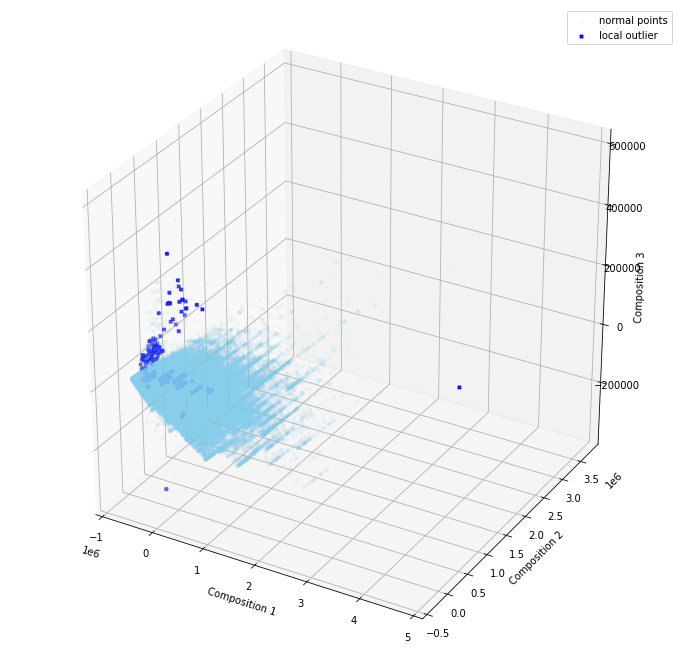

In [ ]:
# 밀도 기반의 국소 이상치 탐지모델 LOF 탐지된 이상치 데이터 시각화

fig = plt.figure(figsize = (12, 12))
plt.title("Local Outlier Factor(LOF)")

ax = fig.add_subplot(111, projection = "3d")

ax.set_xlabel("Composition 1")
ax.set_ylabel("Composition 2")
ax.set_zlabel("Composition 3")

ax.scatter(NCB_IF_reduction[0],
           NCB_IF_reduction[1],
           NCB_IF_reduction[2],
           c = "skyblue", lw = 1, s = 8, alpha = 0.05, label = "normal points")

ax.scatter(NCB_IF_reduction.iloc[lof_index, 0],
           NCB_IF_reduction.iloc[lof_index, 1],
           NCB_IF_reduction.iloc[lof_index, 2],
           c = "blue", lw = 2, s = 10, marker = "x", label = "local outlier")

ax.legend()
plt.show()

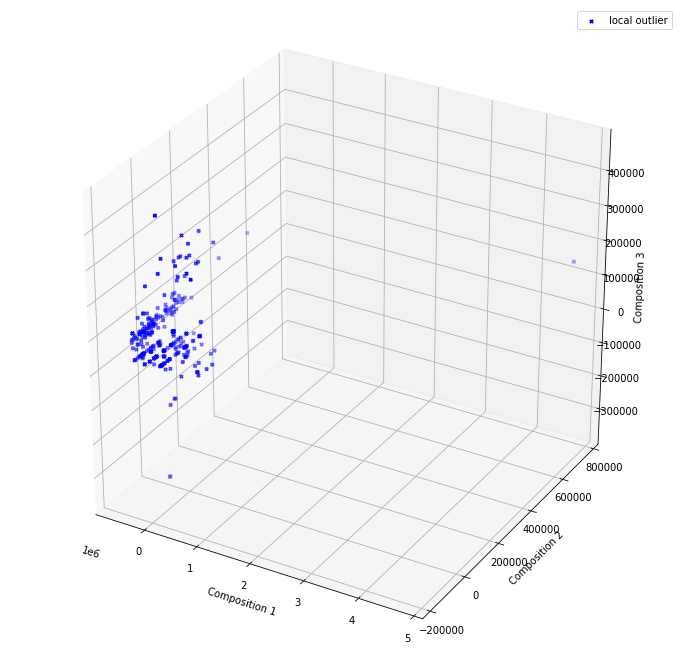

In [ ]:
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111, projection = "3d")

ax.set_xlabel("Composition 1")
ax.set_ylabel("Composition 2")
ax.set_zlabel("Composition 3")

ax.scatter(NCB_IF_reduction.iloc[lof_index, 0],
           NCB_IF_reduction.iloc[lof_index, 1],
           NCB_IF_reduction.iloc[lof_index, 2],
           c = "blue", lw = 2, s = 10, marker = "x", label = "local outlier")

ax.legend()
plt.show()

In [ ]:
# LOF값 1보다 커질수록 밀도가 낮음을 의미하므로 이상치로 판정, 임계값 설정

NCB_IF_reduction["Local_outlier_Factor"].describe()
  # [이론대로 적용하면 이상치 없음]

count    313975.000000
mean         -1.123518
std           0.603598
min        -127.733772
25%          -1.074942
50%          -1.018883
75%          -0.997310
max          -0.942599
Name: Local_outlier_Factor, dtype: float64

In [ ]:
len(NCB_IF_reduction[NCB_IF_reduction["Local_outlier_Factor"] > -0.96])
  # [514행이 국소 이상치로 탐지]

514

In [ ]:
lof_threshold_index = NCB_IF_reduction[NCB_IF_reduction["Local_outlier_Factor"] > -0.96].index.tolist()

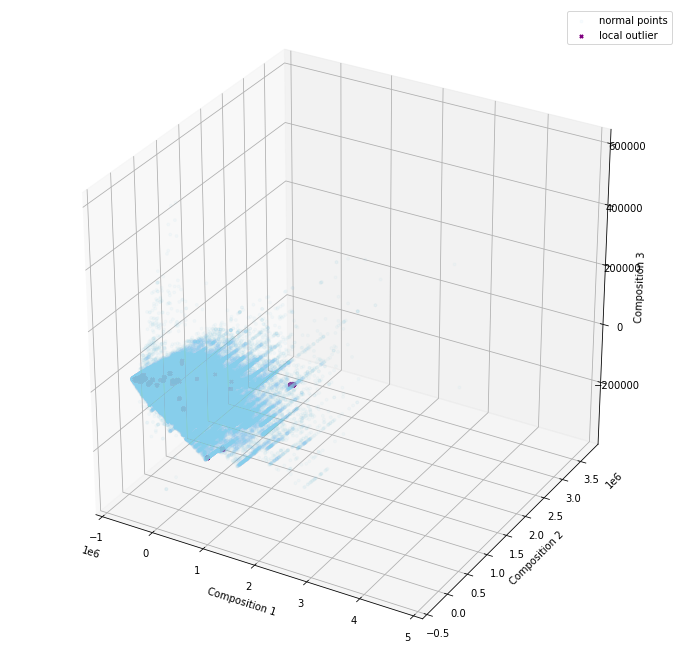

In [ ]:
# LOF의 임계값 -0.96을 초과하여 탐지된 이상치 데이터 시각화


fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111, projection = "3d")

ax.set_xlabel("Composition 1")
ax.set_ylabel("Composition 2")
ax.set_zlabel("Composition 3")

ax.scatter(NCB_IF_reduction[0],
           NCB_IF_reduction[1],
           NCB_IF_reduction[2],
           c = "skyblue", lw = 1, s = 8, alpha = 0.05, label = "normal points")

ax.scatter(NCB_IF_reduction.iloc[lof_threshold_index, 0],
           NCB_IF_reduction.iloc[lof_threshold_index, 1],
           NCB_IF_reduction.iloc[lof_threshold_index, 2],
           c = "purple", lw = 2, s = 10, marker = "x", label = "local outlier")

ax.legend()
plt.show()

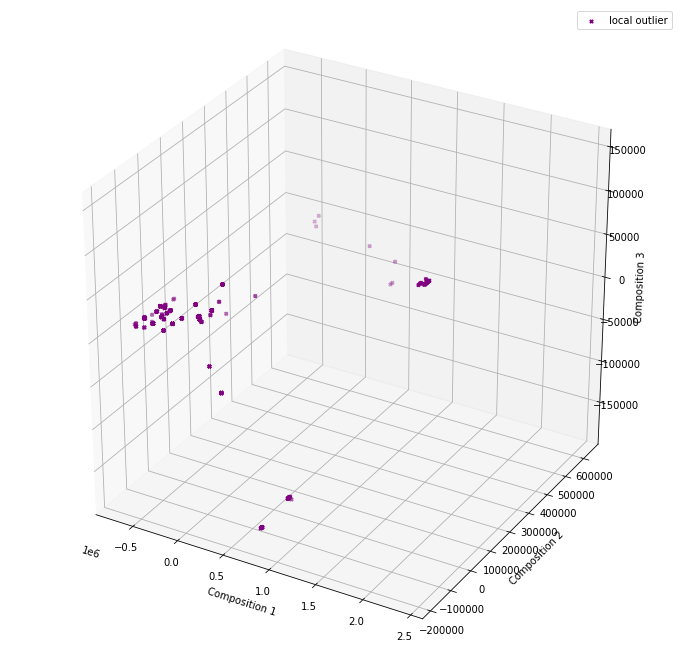

In [ ]:
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111, projection = "3d")

ax.set_xlabel("Composition 1")
ax.set_ylabel("Composition 2")
ax.set_zlabel("Composition 3")

ax.scatter(NCB_IF_reduction.iloc[lof_threshold_index, 0],
           NCB_IF_reduction.iloc[lof_threshold_index, 1],
           NCB_IF_reduction.iloc[lof_threshold_index, 2],
           c = "purple", lw = 2, s = 10, marker = "x", label = "local outlier")

ax.legend()
plt.show()

##### 7. K-means Cluster에서 멀리 떨어진 점을 이상치로 탐지(Global Outlier)

https://velog.io/@choonsik_mom/outlier-detection%EC%9D%B4%EC%83%81%EA%B0%92-%ED%83%90%EC%A7%80-%EA%B5%AC%ED%98%84

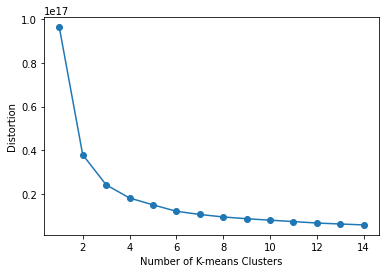

In [ ]:
distortions = []

for i in range(1, 15, 1):
  kmeans = KMeans(
      n_clusters = i,
      init = "k-means++", n_init = 10, max_iter = 300,
      random_state = 2021
  )
  kmeans.fit(NCB_IF_reduction.iloc[:, 0:3])
  distortions.append(kmeans.inertia_)
    # [군집의 평균과의 오차제곱합]

plt.plot(
    range(1, 15, 1),
    distortions,
    marker = "o"
)
plt.xlabel("Number of K-means Clusters")
plt.ylabel("Distortion")
plt.show()
  # [최적의 군집 수 K = 2, 3] elbow method

In [ ]:
kmclust = KMeans(n_clusters = 3,
                 n_init = 10, max_iter = 300,
                 random_state = 2021)

In [ ]:
NCB_kmclust = NCB_IF_reduction.iloc[:, 0:3]

In [ ]:
NCB_kmclust.columns = ["PC1", "PC2", "PC3"]

In [ ]:
kmclust_outlier = kmclust.fit(NCB_kmclust)

In [ ]:
NCB_kmclust["kmcluster"] = kmclust_outlier.labels_

In [ ]:
kmclust_outlier.cluster_centers_

array([[ 9.62848341e+04,  9.14997067e+02, -2.65508215e+03],
       [-4.43756869e+05,  6.18791560e+02,  2.58832375e+03],
       [ 9.32020276e+05, -3.91175394e+03, -2.24581766e+02]])

In [ ]:
centroid = kmclust_outlier.cluster_centers_

In [ ]:
NCB_kmclust["kmcluster"].value_counts()

1    135182
0    127478
2     51315
Name: kmcluster, dtype: int64

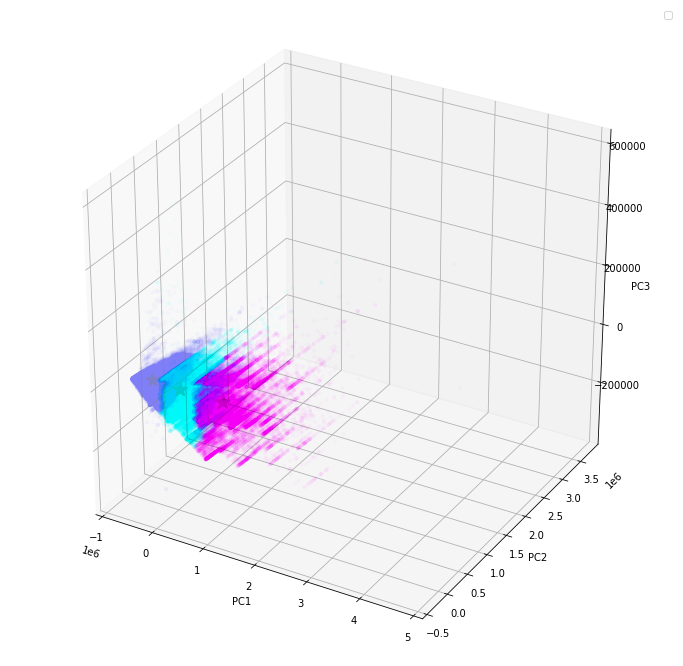

In [ ]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection = "3d")

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

ax.scatter(NCB_kmclust.PC1,
           NCB_kmclust.PC2,
           NCB_kmclust.PC3,
           alpha = 0.02, s = 10,
           cmap = "cool", c = NCB_kmclust.kmcluster)

ax.scatter(
    centroid[:, 0],
    centroid[:, 1],
    centroid[:, 2],
    c = "black",
    s = 200,
    marker = "*"
)
  # [각 군집의 센터(평균값) 검은색 별표, 사이즈 200으로 설정]

ax.legend()
plt.show()

In [ ]:
kmclust_outlier.cluster_centers_[NCB_kmclust.kmcluster, 0]
  # [k-means 군집은 3가지인데, 해당 군집에서 PC1에 대응되는 센터값]

array([-443756.86906407,  932020.2757189 ,   96284.8340722 , ...,
       -443756.86906407, -443756.86906407,   96284.8340722 ])

In [ ]:
kmclust_outlier.cluster_centers_[NCB_kmclust.kmcluster, 1]
  # [k-means 군집은 3가지인데, 해당 군집에서 PC2에 대응되는 센터값]

array([  618.79156009, -3911.75393813,   914.99706659, ...,
         618.79156009,   618.79156009,   914.99706659])

In [ ]:
kmclust_outlier.cluster_centers_[NCB_kmclust.kmcluster, 2]
  # [k-means 군집은 3가지인데, 해당 군집에서 PC3에 대응되는 센터값]

array([ 2588.32375223,  -224.58176563, -2655.08214594, ...,
        2588.32375223,  2588.32375223, -2655.08214594])

In [ ]:
# 군집의 중심점에서 각 데이터까지의 유클리디안(L2) 거리를 계산하는 알고리즘
  # 1. (각 군집 내 데이터 - 해당 군집의 평균값, centroid[:, i])의 제곱 후 루트값을 계산하여 새로운 데이터 프레임 생성
  # 2. df.sort_index(ascending = False)를 이용하여 내림차순 정렬
  # K-means cluster에서 멀리 떨어진 이상치로 판정하는 임계값(데이터 수) 결정
  # Outlier Detection with K-Means Clustering Plot 시각화

def Kmeans_distance(PC1, PC2, PC3, label):

  center_PC1 = kmclust_outlier.cluster_centers_[label, 0]
  center_PC2 = kmclust_outlier.cluster_centers_[label, 1]
  center_PC3 = kmclust_outlier.cluster_centers_[label, 2]

  euclid_dist = np.sqrt(
      (PC1 - center_PC1)**2 + (PC2 - center_PC2)**2 +  (PC3 - center_PC3)**2
  )
  return np.round(euclid_dist, 2)

NCB_kmclust["L2distance"] = Kmeans_distance(NCB_kmclust.PC1,
                                            NCB_kmclust.PC2,
                                            NCB_kmclust.PC3,
                                            label = NCB_kmclust.kmcluster)

In [ ]:
NCB_kmclust["L2distance"].unique()
  # [None 에러] 함수의 반환값(return)을 지정하지 않아서 생긴 오류

array([239053.86, 351514.22, 225027.82, ..., 271428.59, 204991.37,
        92675.24])

In [ ]:
NCB_kmclust.sort_values(["L2distance"], ascending = False, inplace = True)

In [ ]:
NCB_kmclust

,PC1,PC2,PC3,kmcluster,L2distance
220480,2.587526e+06,3.567455e+06,129209.309649,2,3938541.75
15123,4.767070e+06,7.619809e+05,151061.251288,2,3913705.01
174704,1.177792e+05,3.697903e+06,-46475.541089,0,3697309.88
273330,1.392082e+05,3.696376e+06,7736.377257,0,3695725.13
273329,1.392082e+05,3.696376e+06,7736.377257,0,3695725.13
...,...,...,...,...,...
4073,-4.439136e+05,-2.711615e+02,418.691374,1,2350.29
197,-4.439658e+05,9.018713e+02,291.586024,1,2323.53
21039,-4.439823e+05,9.274766e+02,335.934308,1,2284.59
113143,-4.439589e+05,9.581940e+02,344.470991,1,2278.35


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


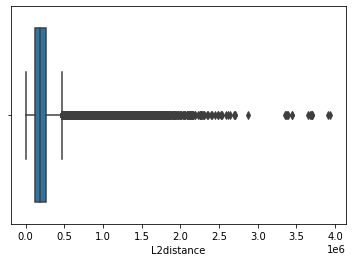

In [ ]:
sns.boxplot(NCB_kmclust["L2distance"])

In [ ]:
kmclust_index = list(NCB_kmclust.head(314).index)
  # [내림차순 정렬하여 가장 높은 거리부터 전체 행의 0.1%인 314행을 이상치로 탐지하도록 임계값 설정]

In [ ]:
kmclust_detected_outlier = NCB_kmclust[NCB_kmclust.index.isin(kmclust_index)]
  # [K-means 군집분석 결과 이상치로 판정된 데이터프레임 생성]

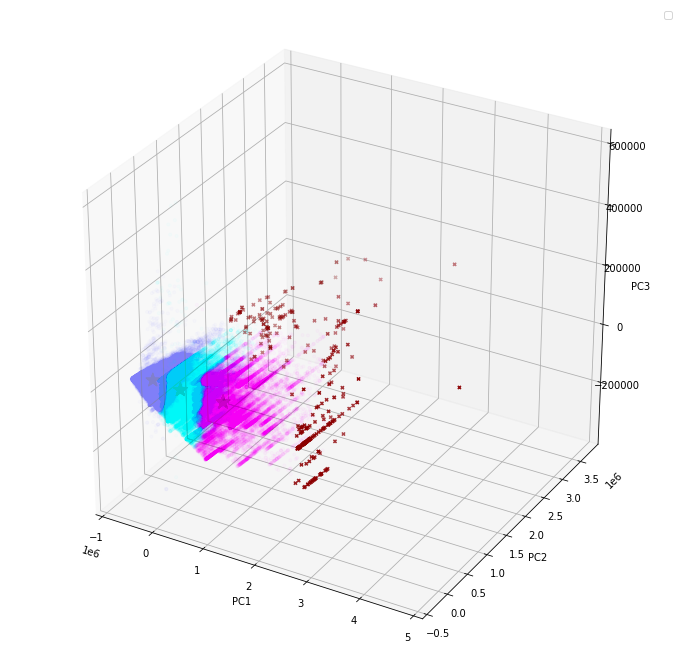

In [ ]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection = "3d")

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

ax.scatter(NCB_kmclust.PC1,
           NCB_kmclust.PC2,
           NCB_kmclust.PC3,
           alpha = 0.02, s = 10,
           cmap = "cool", c = NCB_kmclust.kmcluster)

ax.scatter(
    centroid[:, 0],
    centroid[:, 1],
    centroid[:, 2],
    c = "black",
    s = 200,
    marker = "*"
)
  # [각 군집의 센터(평균값) : 검정 별표, 사이즈 200으로 설정]

ax.scatter(
    kmclust_detected_outlier.PC1,
    kmclust_detected_outlier.PC2,
    kmclust_detected_outlier.PC3,
    c = "darkred",
    s = 10,
    marker = "x"
)
  # [이상치 : 짙은 빨강 엑스, 사이즈 10으로 설정]

ax.legend()
plt.show()

##### 8. HDBSCAN(Global Outlier, Hierarchical Density-Based Spatial Clustering of Applications with Noise)

밀도 기반의 군집분석을 계층적 군집분석 알고리즘으로 변환하여 확장한 비지도학습 모델

* 밀도 기반의 공간 변환
* 거리 가중치 그래프의 최소 범위의 트리 구성(get_min_span_tree = True)
* 연결된 구성요소의 클러스터 계층 구성
* 최소 클러스터 크기 기준으로 클러스터 계층 압축
* 응축된 트리에서 안정적 클러스터 추출

https://godongyoung.github.io/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D/2019/07/15/HDBSCAN-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0-(with-python).html

In [ ]:
outlier_hdbscan = hdbscan.HDBSCAN(min_cluster_size = 4,
                                  gen_min_span_tree = True)

In [ ]:
outlier_hdbscan.fit(NCB_IF_reduction2.iloc[:, 0:2])

In [ ]:
outlier_hdbscan.labels_.max()

In [ ]:
outlier_hdbscan.outlier_scores_

In [ ]:
sns.distplot(outlier_hdbscan.outlier_scores_[
    np.isfinite(outlier_hdbscan.outlier_scores_)
    ], rug = True)

In [ ]:
'''
outlier_hdbscan.minimum_spanning_tree_.plot(
    edge_cmap = "viridis",
    edge_alpha = 0.5,
    node_size = 50,
    edge_linewidth = 2
)
  # [UserWarning: Too many data points for safe rendering of an minimal spanning tree!
  warn('Too many data points for safe rendering of an minimal spanning tree!')]

outlier_hdbscan.single_linkage_tree_.plot(
    cmap = "viridis",
    colorbar = True)
  # [RecursionError: maximum recursion depth exceeded while getting the str of an object]

outlier_hdbscan.condensed_tree_.plot()
  # [클러스터 트리 압축]
'''



---



### 이상치 탐지 알고리즘 밑바닥부터 이해하기

* isolationForest
https://github.com/scikit-learn/scikit-learn/blob/98cf537f5/sklearn/ensemble/_iforest.py#L28

* local outlier factor
https://github.com/scikit-learn/scikit-learn/blob/98cf537f5c538fdbc9d27b851cf03ce7611b8a48/sklearn/neighbors/_lof.py

* K-means clustering
https://github.com/scikit-learn/scikit-learn/blob/98cf537f5c538fdbc9d27b851cf03ce7611b8a48/sklearn/cluster/_k_means_common.pyx

* DBSCAN
https://github.com/scikit-learn/scikit-learn/blob/98cf537f5c538fdbc9d27b851cf03ce7611b8a48/sklearn/cluster/_dbscan.py

##### Pseudo Code of DBSCAN Algorithm

```
cluster_index = 0

for point_x in dataset:
  if point_x already has a label:
    continue
  if count_neighbors( point_x1_eps ) >= min_samples:
    point_x is a core point with ia = cluster_index

    for neighbor in neighbors( point_x1_eps ):
      if neighbor has no cluster ia:
        neighbor_ia = cluster_index
        if neighbor is core:
          also visit all their neighbors
  else:
    point_x is noise

cluster_index ++
```

https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf

In [ ]:
NCB_DBscan = NCB_IF_reduction.iloc[:, 0:3]

In [ ]:
NCB_DBscan.columns = ["PC1", "PC2", "PC3"]

In [ ]:
'''
for x_index, point_x in enumerate(np.array(NCB_DBscan)):
  print("index", x_index, "point", point_x)
'''

In [ ]:
class DBscan:
  def __init__(self, min_samples: int, epsilon: float):
    self.min_samples = min_samples
    self.epsilon = epsilon
      # [필요한 이웃 수와 엡실론 반경의 거리 타입 어노테이션 및 초기화]

  def get_neighbors(self, x_index: int, dataset: np.array) -> List:
    neighbor_indices = []
      # [이웃 지수 리스트 생성]
    for y_index, point_y in enumerate(dataset):
      if x_index != y_index and np.linalg.norm(dataset[x_index] - point_y) < self.epsilon:
        # [넘파이 벡터 정규화]
          neighbor_indices.append(y_index)
    return neighbor_indices

  def is_core(self, x_index: int, dataset: np.array) -> bool:
    return len(self.get_neighbors(x_index, dataset)) >= self.min_samples

  def visit_neighbors(self, x_index: int, dataset: np.array, cluster_index: int) -> None:
      for neighbor_index in self.get_neighbors(x_index, dataset):
        if self.cluster_per_point[neighbor_index] == -1:
          self.cluster_per_point[neighbor_index] = cluster_index
          if self.is_core(neighbor_index, dataset):
            self.visit_neighbors(neighbor_index, dataset, cluster_index)

  def run_clustering(self, dataset: np.array):
    clsuter_index = 0
    cluster_per_point = [-1] * len(dataset)

    for x_index, point_x in enumerate(dataset):
        # [인덱스와 원소로 이루어진 튜플을 만드는 enumerate()]

        if self.cluster_per_point[x_index] != -1:
          continue
            # [엡실론 반경의 이웃수(eps-neighbors) 집계]

        if self.is_core(x_index, dataset):
          # [엡실론 반경의 이웃 수보다 데이터가 적다면]
          self.cluster_per_point[x_index] = cluster_index
            # [이웃점 모두 순회]
          self.visit_neighbors(x_index, dataset, cluster_index)

        cluster_index += 1
    return cluster_per_point

In [ ]:
dbscan_instance = DBscan(min_samples = 300, epsilon = 0.0005)

In [ ]:
# dbclust = dbscan_instance.run_clustering(dataset = NCB_DBscan)
  # [AttributeError: 'DBscan' object has no attribute 'cluster_per_point']

In [ ]:
minMaxScaler = MinMaxScaler(feature_range = (0,1))

In [ ]:
minMaxScaler.fit(NCB_DBscan)

MinMaxScaler()

In [ ]:
NCB_MinMax_DBscan = pd.DataFrame(minMaxScaler.transform(NCB_DBscan), columns = [f"PC{n+1}" for n in range(NCB_DBscan.shape[1])])

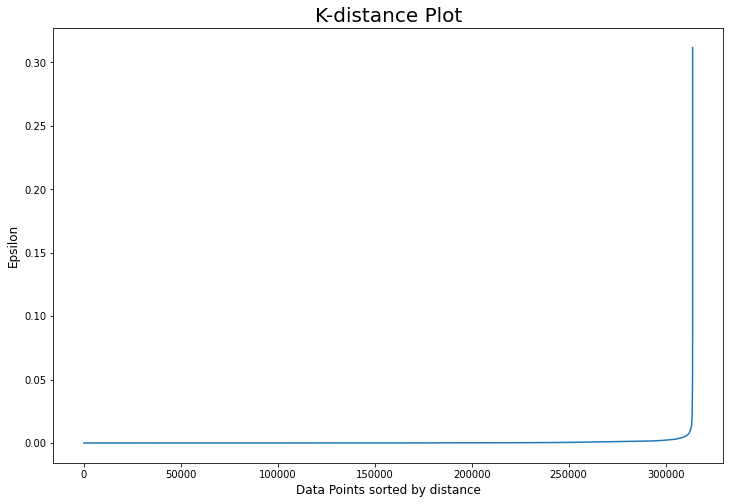

In [ ]:
# epsilon(거리) 크기 정하기 위한 K-distance Plot

neighbors, knn, distances, indices, K_distances = 0, 0, 0, 0, 0

neighbors = NearestNeighbors(n_neighbors = 2)
knn = neighbors.fit(NCB_MinMax_DBscan)
distances, indices = knn.kneighbors(NCB_MinMax_DBscan)

K_distances = np.sort(distances, axis = 0)
K_distances = K_distances[:, 1]

plt.figure(figsize = (12, 8))
plt.plot(K_distances)

plt.title("K-distance Plot", fontsize = 20)
plt.xlabel("Data Points sorted by distance", fontsize = 12)
plt.ylabel("Epsilon", fontsize = 12)

plt.show()
  # [최대 Epsilon 값이 0.05에 근접하며, minimum points 이웃 데이터의 수는 3000,000/100 = 300으로 최적화]

In [ ]:
MinMax_dbscan = DBSCAN(
    algorithm = "kdtree",
    eps = 0.5,
    metric = "euclidean",
    metric_params = None,
    min_samples = 5,
    n_jobs = None,
    p = None
)
  # [0~1로 최소최대 정규화한 3차원 축소된 데이터로 DBSCAN 수행 시 램 용량 초과하여 런타임 에러 발생]
  # [밀도 기반의 군집분석의 시간복잡도 = O(n*logn)]
  # [print(round(313975 * math.log10(313975))) = 1,725,888]

In [ ]:
outlier_MinMax_dbscan = MinMax_dbscan.fit(NCB_MinMax_DBscan)

In [ ]:
df_outlier_MinMax_dbscan = NCB_MinMax_dbscan[outlier_MinMax_dbscan.labels_ == -1]
print(df_outlier_MinMax_dbscan.shape)
df_outlier_MinMax_dbscan.head()